##Librerias

In [1]:
import math
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder
) 

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##Realizamos el tratamiento de las variables

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_hotels_train = pd.read_csv('drive/MyDrive/hotels_train.csv')

In [5]:
df_hotels_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [6]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

In [7]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')

Retiramos los nulos

In [8]:
#Company
df_hotels_train['company'].fillna(-9999, inplace=True)

In [9]:
#Agent
df_hotels_train['agent'].fillna(-9999, inplace=True)

In [10]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [11]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

Analizamos los outliers

In [12]:
#columnas:(lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces)
media_lead_time=np.mean(df_hotels_train.lead_time)
std_lead_time=np.std(df_hotels_train.lead_time)
df_zscore = pd.DataFrame()
df_zscore['z_lead_time']=(df_hotels_train.lead_time - media_lead_time)/std_lead_time
df_zscore[df_zscore['z_lead_time']>3]


,z_lead_time
15,3.186066
51,3.402834
95,3.086713
426,3.691859
576,4.640223
...,...
61579,3.655731
61695,3.213162
61761,3.466059
61783,3.086713


In [13]:
for i in range(len(df_zscore['z_lead_time'])):
  if df_zscore.z_lead_time[i] > 3:
    df_hotels_train.lead_time[i] = round(media_lead_time)

<ipython-input-13-6a0a74c2d425>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.lead_time[i] = round(media_lead_time)


In [14]:
#Normalizamos previus cancellation
for i in range(len(df_hotels_train.previous_cancellations)):
  if df_hotels_train.previous_cancellations[i] > 10:
    df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

<ipython-input-14-66f8767a13d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [15]:
media_previous_bookings_not_canceled=np.mean(df_hotels_train.previous_bookings_not_canceled)
for i in range(len(df_hotels_train.previous_bookings_not_canceled)):
  if df_hotels_train.previous_bookings_not_canceled[i] > 30:
    df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)

<ipython-input-15-c7822855a731>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)


In [16]:
#Normalizamos los valores atipicos de booking change
for i in range(len(df_hotels_train.booking_changes)):
  if df_hotels_train.booking_changes[i] > 10:
    df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

<ipython-input-16-83ddfe064c16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [17]:
media_days_in_waiting_list = np.mean(df_hotels_train.days_in_waiting_list)

for i in range(len(df_hotels_train.days_in_waiting_list)):
  if df_hotels_train.days_in_waiting_list[i] > 100:
    df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)

<ipython-input-17-bc59f9949979>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)


In [18]:
media_required_car_parking_spaces = np.mean(df_hotels_train.required_car_parking_spaces)

for i in range(len(df_hotels_train.required_car_parking_spaces)):
  if df_hotels_train.required_car_parking_spaces[i] > 7:
    df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)

<ipython-input-18-d22d66d29b29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)


In [19]:

df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

In [20]:
df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] <= 2 and df_hotels_train.babies[i] >= 8:
    df_hotels_train = df_hotels_train.drop(index = [i])
    

df_hotels_train.reset_index(drop=True, inplace=True)

In [21]:
media_adults=np.mean(df_hotels_train.adults)

for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] >= 25:
    df_hotels_train.adults[i] = round(media_adults)

<ipython-input-21-8ab05d604988>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.adults[i] = round(media_adults)


In [22]:
df_hotels_train.reset_index(drop=True, inplace=True)

for i in range(len(df_hotels_train)):
  if df_hotels_train.stays_in_week_nights[i] == 0 and df_hotels_train.stays_in_weekend_nights[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

Eliminamos id (recordar que la vamos a necesitar mas tarde)

In [23]:
eliminar_columnas = ['id'] # -> Recordar que el id lo vamos a necesitar para machear en kaggle
                                                                      
df_hotels_train.drop(eliminar_columnas, axis='columns', inplace=True)

## Realizamos un encode de las variables

In [24]:
# Realizamos el one hot encoding, con scikit learn.
# Por cada columna a encodear, hacer un fit transform. Dropear la columna, y agregar las columnas nuevas con el nombre adecuado
df_hotels_train_to_encode = df_hotels_train.copy()
cols_a_encodear = ['hotel','arrival_date_month','customer_type','meal', 'distribution_channel','market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'country']
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist') # Siempre se elimina la primera columna, o el feature entero si solo tiene un valor (no aporta informacion).
transformer = make_column_transformer(
    (ohe, cols_a_encodear),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [25]:
df_target = df_hotels_train['is_canceled']
hotels_train_encoded = transformer.fit_transform(df_hotels_train_to_encode.drop('is_canceled', axis=1)) # Se dropea is_canceled, porque no hace falta encodearlo, y ademas la instancia de test no va a tener esa columna.

In [26]:
df_hotels_train_encoded = pd.DataFrame(
    hotels_train_encoded.toarray(), 
    columns=transformer.get_feature_names_out()
)

#Mostramos las primera 10 columnas de country, ya que el resto tiene una cantidad bajisima de datos y no aportan demasiado
country_cols = df_hotels_train_encoded.columns[df_hotels_train_encoded.columns.str.startswith('country_')]
selected_columns = (df_hotels_train_encoded[country_cols] != 0).sum()
top_cols = selected_columns.nlargest(10).index
other_countries = [col for col in country_cols if col not in top_cols]
df_hotels_train_encoded['country_other'] = df_hotels_train_encoded[other_countries].sum(axis=1)
df_hotels_train_encoded.drop(other_countries, axis=1, inplace=True)   

In [27]:
df_hotels_train_encoded.head(1)

,hotel_Resort Hotel,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,country_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,-9999.0,0.0,115.5,0.0,1.0,0.0


##Ensambles

##SVM

Importamos las librerias para utilizar svm

In [28]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Antes de utilizar svm normalizaremos los datos para obtener mejores resultados

In [30]:
#Creo conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train_encoded.values, df_target.values, test_size=0.2, random_state=0)

#Normalizo para luego utiizar en nuestro modelo
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

Probamos el modelo 

In [31]:
#OBSERVACION: Esto tarda bastante en ejecutar y hasta creo que no es necesario tenerlo, pero o dejo por las dudas

#Construyo un modelo SVM  
#svm_norm = SVC()

#Lo entreno con los datos escalados con normalizacion
#svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
#y_pred_norm = svm_norm.predict(x_test_norm)
#metricas(y_pred_norm,y_test)

SVM - KERNELS

Utilizaremos el modelo radial, primero buscaremos optimizar los hiper parametros utilizando grid search para encontrar los mejores "C" y "gamma"

In [32]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

svc = SVC()
params = {'C':[3,4,6,10,15,30], 'kernel':['rbf','poly'], 'gamma':[1,3,4,7,5,8,3]}

#Metrica que quiero optimizar 
scorer_fn = make_scorer(sk.metrics.f1_score) 


grid_s = GridSearchCV(estimator = svc, param_grid = params, cv = 5, scoring = scorer_fn )  ) 
grid_s.fit(x_train_norm, y_train)



#Mejores hiperparametros
print(grid_s.best_params_)

#Mejor métrica
print(grid_s.best_score_)
"""

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import make_scorer\n\nsvc = SVC()\nparams = {'C':[3,4,6,10,15,30], 'kernel':['rbf','poly'], 'gamma':[1,3,4,7,5,8,3]}\n\n#Metrica que quiero optimizar \nscorer_fn = make_scorer(sk.metrics.f1_score) \n\n\ngrid_s = GridSearchCV(estimator = svc, param_grid = params, cv = 5, scoring = scorer_fn )  ) \ngrid_s.fit(x_train_norm, y_train)\n\n\n\n#Mejores hiperparametros\nprint(grid_s.best_params_)\n\n#Mejor métrica\nprint(grid_s.best_score_)\n"

Una vez terminada la busquda de hiper parametros creamos el clasificador y mostramos la matriz de confusion

In [33]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos normalizados

#clf = SVC(kernel='rbf', C=5, gamma=10) # -> Aca tenemos que encontrar los mejores hipers params
#clf.fit(x_train_norm, y_train)

#Hago la predicción y calculo las métricas
#y_pred_rad=clf.predict(x_test_norm)
#metricas(y_pred_rad,y_test)

##XGBoost

In [34]:
#Importamos las librerias
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
import pydotplus
from IPython.display import Image  

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('always')

Separamos un set de evaluacion exclusivo para Xg (esto lo haremos en todos los modelos, para tener un poco mas de orden)

In [35]:
#Separo un set de Evaluacion
x_train_Xg, x_test_Xg, y_train_Xg, y_test_Xg = train_test_split(df_hotels_train_encoded.values, 
                                                    df_target.values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_target.values) #estratificado para mantener proporcion


print('# Datos Entrenamiento: {}'.format(len(x_train_Xg))) #- > cantidad de datos en cada set
print('# Datos Prueba: {}'.format(len(x_test_Xg)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_Xg,y_test_Xg]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 49160
# Datos Prueba: 12290
% Positivos Entrenamiento: 50.201
% Positivos Prueba: 50.203


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Construimos el modelo y lo entrenamos

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train_Xg, y_train_Xg) #Entrenamos el modelo

Evaluamos el set y mostramos la matriz 

AUC: 0.9507899413141809
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6120
           1       0.87      0.88      0.87      6170

    accuracy                           0.87     12290
   macro avg       0.87      0.87      0.87     12290
weighted avg       0.87      0.87      0.87     12290



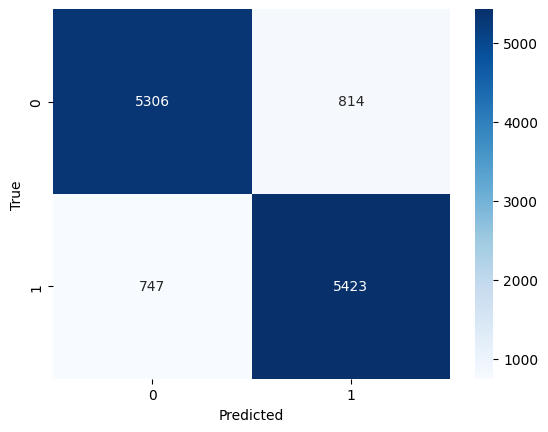

In [53]:
y_pred_proba = xgb_model.predict_proba(x_test_Xg)[:, 1]
print('AUC:',roc_auc_score(y_test_Xg, y_pred_proba)) #mostramos el area bajo la curva

#Realizamos el pred y mostramos la matriz de confusion
y_pred_Xg = xgb_model.predict(x_test_Xg)

cm = confusion_matrix(y_test_Xg,y_pred_Xg)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Metricas
print(classification_report(y_test_Xg,y_pred_Xg))


Tenemos unas metricas bastante mas altas que el resto de ensambles en primera instancia. Este modelo es bastante mas potente que el resto de nuestros modelos hasta ahora.

Ahora, buscaremos llos hiperparametros para optimizar el modelo y conseguir un mejor rendimiento

In [55]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV

params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)} #Hiper params que queremos mejorar

#Folds
kfoldcv = StratifiedKFold(n_splits=5)

#Metrica que buscamos mejorar 
scorer_fn = make_scorer(sk.metrics.f1_score) 


#Ramdom Search CV
clasificador = xgb.XGBClassifier()
randomcv = RandomizedSearchCV( clasificador, params_grid, n_jobs=10, scoring = scorer_fn,cv=kfoldcv, n_iter=10, verbose = 1)
#randomcv.fit(x_train_Xg,y_train_Xg)

#print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
#gb = randomcv.best_estimator_